In [1]:
import time
import glob
import torch
import os
import gdal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1 _CudaDeviceProperties(name='Quadro K620', major=5, minor=0, total_memory=2048MB, multi_processor_count=3)


In [34]:
def imShow(path):
    import cv2
    import matplotlib.pyplot as plt
    %matplotlib inline

    image = cv2.imread(path)
    height, width = image.shape[:2]
    resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    plt.axis("off")
    #plt.rcParams['figure.figsize'] = [10, 5]
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

In [52]:
!python detect.py \
--geo \
--save-geom \
--source "C:\Users\lerryw\Google Drive\satellite_dataset\worldview\416_validation\tradewinds0017_0017.tif" \
--save-label \
--cfg "C:\Users\lerryw\Google Drive\satellite_dataset\worldview\cfg\yolov3_spp_1cls_op.cfg" \
--weights "C:\Users\lerryw\Google Drive\satellite_dataset\worldview\weights\best_oilpalm_wv_500.pt" \
--names "C:\Users\lerryw\Google Drive\satellite_dataset\worldview\op.names" \
--conf-thres=0.2 \
--iou-thres=0.1 \
--augment

# imShow('./output/Keresa_Pansharped_765.tif')

Namespace(agnostic_nms=False, augment=True, cfg='C:\\Users\\lerryw\\Google Drive\\satellite_dataset\\worldview\\cfg\\yolov3_spp_1cls_op.cfg', classes=None, conf_thres=0.2, device='', fourcc='mp4v', geo=True, half=False, img_size=512, iou_thres=0.1, names='C:\\Users\\lerryw\\Google Drive\\satellite_dataset\\worldview\\op.names', output='./output', save_geom=True, save_label=True, save_txt=False, source='C:\\Users\\lerryw\\Google Drive\\satellite_dataset\\worldview\\416_validation\\tradewinds0017_0017.tif', view_img=False, weights='C:\\Users\\lerryw\\Google Drive\\satellite_dataset\\worldview\\weights\\best_oilpalm_wv_500.pt')
Using CUDA device0 _CudaDeviceProperties(name='Quadro K620', total_memory=2048MB)

Model Summary: 225 layers, 6.25733e+07 parameters, 6.25733e+07 gradients
image 1/1 C:\Users\lerryw\Google Drive\satellite_dataset\worldview\416_validation\tradewinds0017_0017.tif: 384x384 134 OP1s, Done. (0.493s)
Results saved to C:\Development\yolov3\./output
Done. (1.879s)


./output/tradewinds0017_0017.tif


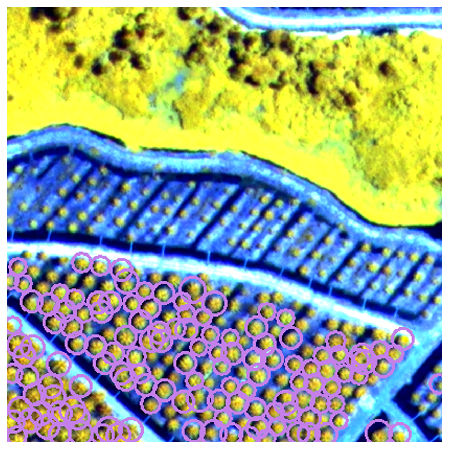

In [53]:
outfd = r"./output/"

import os
for filename in os.listdir(outfd):
    if filename[-4:] == ".tif":
        img = os.path.join(outfd,filename)
        print(img)
        imShow(img)

In [29]:
# from utils.utils import to_tiles
# path_wv=r"C:\Map\Deep_learning\digital_globe\011802594010_01\Processing\18AUG31030458-M2AS-011802594010_01_P001_B7532.tif"
# outFd = r"C:\Map\Deep_learning\digital_globe\011802594010_01\tile7532_416"
# to_tiles(path_wv,outFd,416,416)

Tiles has been save in C:\Map\Deep_learning\digital_globe\011802594010_01\tile7532_416
Done! Total tiles : 441


In [19]:
# from models import convert
# convert(cfg=r'C:\Users\lerryw\Google Drive\satellite_dataset\worldview\cfg\yolov3_spp_1cls_op.cfg',
#         weights=r'C:\Users\lerryw\Google Drive\satellite_dataset\worldview\weights\best_oilpalm_wv_300.pt')

Model Summary: 225 layers, 6.25733e+07 parameters, 6.25733e+07 gradients
Success: converted 'C:\Users\lerryw\Google Drive\satellite_dataset\worldview\weights\best_oilpalm_wv_300.pt' to 'converted.weights'


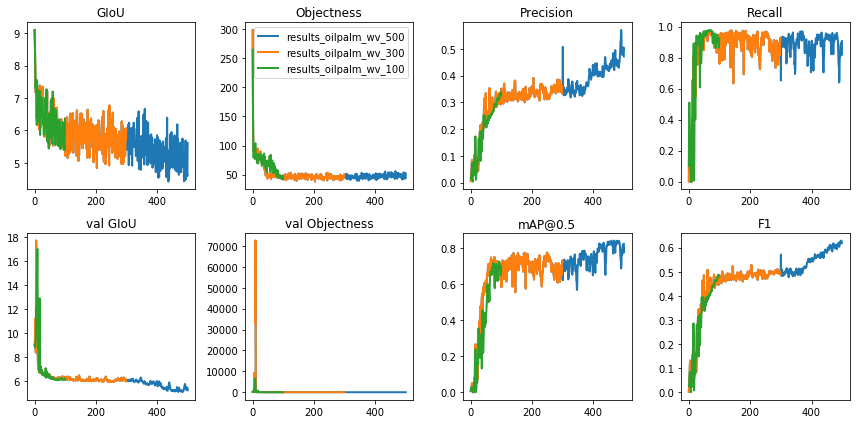

In [24]:
import glob
import math
import os
import random
import shutil
import subprocess
import time
from copy import copy
from pathlib import Path
from sys import platform

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
def plots(start=0, stop=0, bucket='', id=()):  # from utils.utils import *; plot_results()
    # Plot training 'results*.txt' as seen in https://github.com/ultralytics/yolov3#training
    fig, ax = plt.subplots(2, 4, figsize=(12, 6), tight_layout=True)
    ax = ax.ravel()
    # s = ['GIoU', 'Objectness', 'Classification', 'Precision', 'Recall',
    #      'val GIoU', 'val Objectness', 'val Classification', 'mAP@0.5', 'F1']
    s = ['GIoU', 'Objectness', 'Precision', 'Recall',
         'val GIoU', 'val Objectness', 'mAP@0.5', 'F1']
    if bucket:
        os.system('rm -rf storage.googleapis.com')
        files = ['https://storage.googleapis.com/%s/results%g.txt' % (bucket, x) for x in id]
    else:
        files = glob.glob(r'C:\Users\lerryw\Google Drive\satellite_dataset\worldview\results\*_wv_*.txt') #+ glob.glob('../../Downloads/results*.txt')

    for f in sorted(files,reverse=True):
        try:
            # results = np.loadtxt(f, usecols=[2, 3, 4, 8, 9, 12, 13, 14, 10, 11], ndmin=2).T
            results = np.loadtxt(f, usecols=[2, 3, 8, 9, 12, 13, 10, 11], ndmin=2).T
            n = results.shape[1]  # number of rows
            x = range(start, min(stop, n) if stop else n)
            for i in range(8):
                y = results[i, x]
                if i in [0, 1, 2, 5, 6, 7]:
                    y[y == 0] = np.nan  # dont show zero loss values
                    # y /= y[0]  # normalize
                ax[i].plot(x, y, marker='', label=Path(f).stem, linewidth=2, markersize=8)
                ax[i].set_title(s[i])
                # if i in [5, 6, 7]:  # share train and val loss y axes
                #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])
        except:
            print('Warning: Plotting error for %s, skipping file' % f)

    ax[1].legend()
    fig.savefig(r'C:\Users\lerryw\Google Drive\satellite_dataset\worldview\results\results.png', dpi=360)

plots()

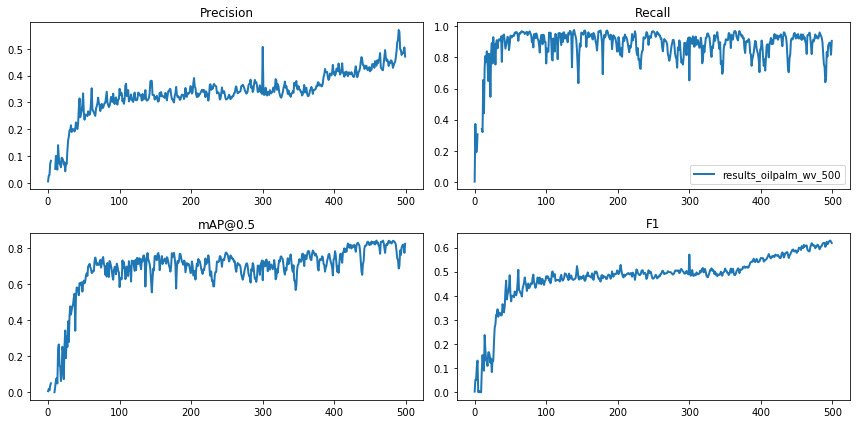

In [18]:
import glob
import math
import os
import random
import shutil
import subprocess
import time
from copy import copy
from pathlib import Path
from sys import platform

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
def plots(start=0, stop=0, bucket='', id=()):  # from utils.utils import *; plot_results()
    # Plot training 'results*.txt' as seen in https://github.com/ultralytics/yolov3#training
    fig, ax = plt.subplots(2, 2, figsize=(12, 6), tight_layout=True)
    ax = ax.ravel()
    s = ['Precision', 'Recall', 'mAP@0.5', 'F1']
    files = glob.glob(r'C:\Users\lerryw\Google Drive\satellite_dataset\worldview\results\results_oilpalm_wv_500.txt') #+ glob.glob('../../Downloads/results*.txt')
    for f in sorted(files):
        try:
            results = np.loadtxt(f, usecols=[8, 9, 10, 11], ndmin=2).T
            n = results.shape[1]  # number of rows
            x = range(start, min(stop, n) if stop else n)
            for i in range(4):
                y = results[i, x]
                if i in [0, 1, 2, 5, 6, 7]:
                    y[y == 0] = np.nan  # dont show zero loss values
                    # y /= y[0]  # normalize
                ax[i].plot(x, y, marker='', label=Path(f).stem, linewidth=2, markersize=8)
                ax[i].set_title(s[i])
                # if i in [5, 6, 7]:  # share train and val loss y axes
                #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])
        except:
            print('Warning: Plotting error for %s, skipping file' % f)

    ax[1].legend()
    fig.savefig(r'C:\Users\lerryw\Google Drive\satellite_dataset\worldview\results\results_oilpalm_wv_500.png', dpi=360)

plots()

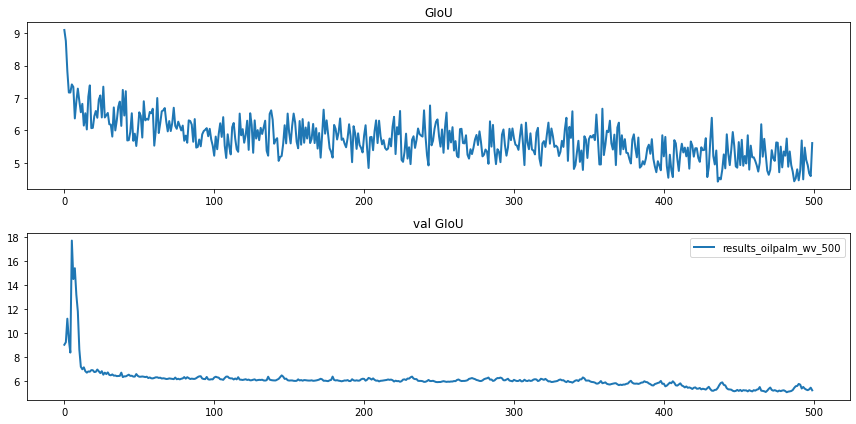

In [19]:
import glob
import math
import os
import random
import shutil
import subprocess
import time
from copy import copy
from pathlib import Path
from sys import platform

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
def plots(start=0, stop=0, bucket='', id=()):  # from utils.utils import *; plot_results()
    # Plot training 'results*.txt' as seen in https://github.com/ultralytics/yolov3#training
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), tight_layout=True)
    ax = ax.ravel()
    # s = ['GIoU', 'Objectness', 'Classification', 'Precision', 'Recall',
    #      'val GIoU', 'val Objectness', 'val Classification', 'mAP@0.5', 'F1']
    s = ['GIoU', 'val GIoU']
    if bucket:
        os.system('rm -rf storage.googleapis.com')
        files = ['https://storage.googleapis.com/%s/results%g.txt' % (bucket, x) for x in id]
    else:
        files = glob.glob(r'C:\Users\lerryw\Google Drive\satellite_dataset\worldview\results\results_oilpalm_wv_500.txt') #+ glob.glob('../../Downloads/results*.txt')
    for f in sorted(files):
        try:
            # results = np.loadtxt(f, usecols=[2, 3, 4, 8, 9, 12, 13, 14, 10, 11], ndmin=2).T
            results = np.loadtxt(f, usecols=[2, 12], ndmin=2).T
            n = results.shape[1]  # number of rows
            x = range(start, min(stop, n) if stop else n)
            for i in range(2):
                y = results[i, x]
                if i in [0, 1, 2, 5, 6, 7]:
                    y[y == 0] = np.nan  # dont show zero loss values
                    # y /= y[0]  # normalize
                ax[i].plot(x, y, marker='', label=Path(f).stem, linewidth=2, markersize=8)
                ax[i].set_title(s[i])
                # if i in [5, 6, 7]:  # share train and val loss y axes
                #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])
        except:
            print('Warning: Plotting error for %s, skipping file' % f)

    ax[1].legend()
#     fig.savefig(r'C:\Users\lerryw\Google Drive\satellite_dataset\worldview\results\results.png', dpi=360)

plots()